In [1]:
import os, os.path
import time
import torch
import sys
import random
import torch.optim as optim
import numpy as np
import shutil
from shutil import copyfile
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms as T
from matplotlib import pyplot as plt
from plot import post_epoch_plot
%matplotlib notebook
from models import SpecialFuseNetModel
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from train import FuseNetTrainer
CWD = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
DATASET_DIR     = os.path.join(CWD,r'data/nyuv2_evaluate/')
checkpoint_dir = 'checkpoints_evaluate/'
# DATASET_DIR     = os.path.join(CWD,r'data/nyuv2')
# checkpoint_dir = 'checkpoints/'

Found 2 images in dataset folder.
Using Index: 0 .
Found 1 images in dataset folder.
[I] - device=cuda
    - seed=42
    - dropout_p=0.4
    - optimizer=None
    - scheduler=None
[I] - Init SpecialFuseNet
    - warm start=True
    - BN momentum=0.1
    - dropout_p=0.4
[I] - Initialize Net.
    - Init type=xavier
    - Init gain=0.02

[I] - default optimizer set: SGD(lr=0.001,momentum=0.9,weight_decay=0.0005)
[I] - default scheduler set: StepSR(step_size=1000,gamma=0.1)
test_batch:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


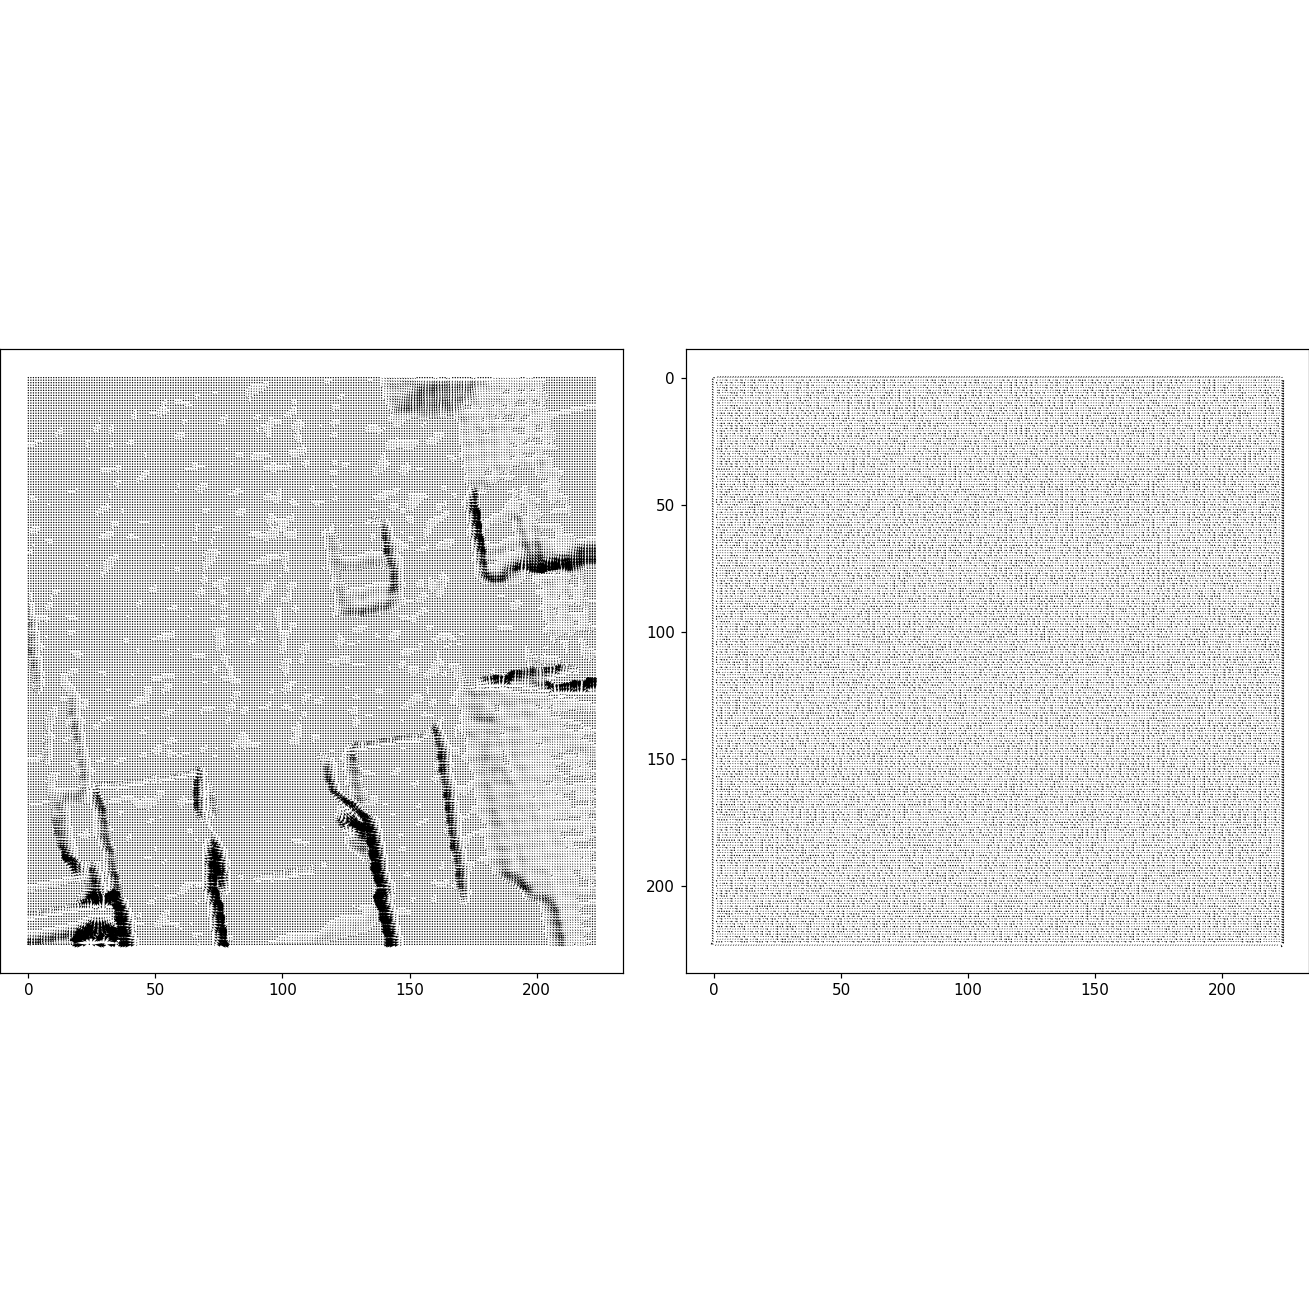

test_batch (Avg. Loss 0.012: 100%|███████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


In [3]:
sys.path.append(checkpoint_dir)
filenames = os.listdir(checkpoint_dir)
models_filenames = set()
for filename in os.listdir(checkpoint_dir):
    #     elif filename.endswith(".pkl"):
    #         text = open(checkpoint_dir + filename, 'r').read()
    #         print(text)
    if filename.endswith(".pt"):
        models_filenames.add(filename[:-3])
for models_filename in models_filenames: 
    copyfile(os.path.join(CWD + '/', checkpoint_dir, models_filename + "_hyperparameters.py"),
             os.path.join(CWD + '/', "hyperparameters.py"))
    from hyperparameters import *
    DATASET_DIR_size = len([name for name in os.listdir(DATASET_DIR + r"/rgb") if os.path.isfile(os.path.join(DATASET_DIR + r"/rgb", name))])
    constant_index = random.randint(0, DATASET_DIR_size - 1)
    print(f'Found {DATASET_DIR_size} images in dataset folder.')
    print(f'Using Index: {constant_index} .')
    rgbd_grads_ds = rgbd_gradients_dataset(root=DATASET_DIR, image_size=IMAGE_SIZE, constant_index=constant_index)
    dl_train, dl_test = rgbd_gradients_dataloader(root=DATASET_DIR,
                                                  batch_size=BATCH_SIZE,
                                                  num_workers=NUM_WORKERS,
                                                  train_test_ratio=TRAIN_TEST_RATIO,
                                                  image_size=IMAGE_SIZE,
                                                  evaluage=True,
                                                  constant_index=constant_index)
    # _ = plot.rgbd_gradients_dataset_first_n(dataset=rgbd_grads_ds,n=5)
    print(f'Found {len(rgbd_grads_ds)} images in dataset folder.')
    if constant_index < 0:
        sample_batch = next(iter(dl_train))
        rgb_size = tuple(sample_batch['rgb'].shape[1:])
        depth_size = tuple(sample_batch['depth'].shape[1:])
        grads_size = tuple(sample_batch['x'].shape[1:])
    else:
        sample_batch = next(iter(dl_test))
        rgb_size = tuple(sample_batch['rgb'].shape[1:])
        depth_size = tuple(sample_batch['depth'].shape[1:])
        grads_size = tuple(sample_batch['x'].shape[1:])
    fusenetmodel = SpecialFuseNetModel(rgb_size=rgb_size,depth_size=depth_size,grads_size=grads_size, device=device)
    fusenetmodel.load_state_dict(torch.load(checkpoint_dir + models_filename + ".pt", map_location=device), strict=False)
    trainer = FuseNetTrainer(model=fusenetmodel, device=device, num_epochs=1)
    trainer.test_epoch(dl_test)       